# Swedes have the best Haskell: Jumping to conclusions with barroom data science 

_This is a Jupyter notebook._

_**Disclaimer**:..._

A few weeks ago I ordered a copy of [Beautiful Vizualization](http://shop.oreilly.com/product/0636920000617.do), which gathers a few stories from data vizualization experts. Not only is it a great read, but it prompted we to give data vizualization a try. Now of course, you first need data, and I couldn't really find a way to display existing data in a way that hadn't been done a thousand times before. 

One evening, I was having a drink with a fellow Haskeller, and as we enumerated the names of other Haskellers living in Zurich as well. Something struck me as odd: Zurich is a small city, in a small country. That sounded like too many Haskellers. Are there actually many more people writing Haskell than I thought or is there an usually high concentration in Switzerland? So I had a question, and this is a short summary of my journey to get the answer.

## Getting ready

There are several topics discussed in this post. First, we'll play a bit with the tools and services I used to get the data. Then, we'll create a few helpers to make it more convenient to handle the data in Haskell. Next we'll pull the data and process it a bit. Finally 

### The setup
Below is a list of the tools and services used throughout this post. I'll introduce them in more depth as we go:

* [stack](https://docs.haskellstack.org/en/stable/README/) and its [nix integration](https://docs.haskellstack.org/en/stable/nix_integration/#nix-integration) to handle and build the Haskell and system dependencies
* [ihaskell](https://github.com/gibiansky/IHaskell) for running the code with the convenience of a [Jupyter](http://jupyter.org/) notebook
* [curl](https://curl.haxx.se/) and [jq](https://stedolan.github.io/jq/) for discovering the APIs

Web services to get the data from:

* [github](https://developer.github.com/v3/) to get some data about Haskell users and their location
* [geonames](http://www.geonames.org/) for country data
* [amcharts](https://www.amcharts.com/) for getting the maps shown in the final infographic

On the Haskell side we'll use

* [wreq](https://hackage.haskell.org/package/wreq) for making the HTTP calls
* [aeson](https://hackage.haskell.org/package/aeson) for decoding the data
* [timeit](https://hackage.haskell.org/package/timeit) for timing a thing or two
* [conduit](https://hackage.haskell.org/package/conduit) for convenience when handling the data
* [HaskellR](https://tweag.github.io/HaskellR/) and its suite of libraries for displaying the data

## Getting a feel for the APIs

Now that that's out of the way, let's get started! We'll need some raw material: a list of Github users. The [github api](https://developer.github.com/v3/) provides us with three endpoints that will come in handy: a [repository search](https://developer.github.com/v3/search/#search-repositories) endpoint, a [repository collaborators](https://developer.github.com/v3/repos/collaborators/) endpoint and a [users](https://developer.github.com/v3/users/) endpoint. We'll get a list of haskell repositories sorted by stars and source our users from there. It will hopefully allow us to get a pool of people who are somewhat involved in the community. We'll try to get a big enough sample so that we don't _only_ consider people who contributed to "star" repos.

### The GitHub API

Here's how the repository [search API](https://developer.github.com/v3/search/#search-repositories) presents itself:

```
GET /search/repositories
```

with three parameters: `q` the search string and `sort` and `order` for specifying in what order we want the results to appear (have a look at the API if you're curious about the different options ). We only care about the Haskell repositories so we'll format the search string like this: `q=language:haskell`. As mentioned, we'll want the repositories to be sorted by stars so we'll use `sort=stars` (and hope github provides a sensible default ordering). Let's get `curl` out:

``` shell
$ curl -s "https://api.github.com/search/repositories?q=language:haskell&sort=stars" | head

{
  "total_count": 57197,
  "incomplete_results": false,
  "items": [
    {
      "id": 571770,
      "name": "pandoc",
      "full_name": "jgm/pandoc",
      "owner": {
        "login": "jgm",
        
```

Well, it looks like it worked! We don't really want to go back and forth between the Github API description page and our terminal, so we'll just try to infer what the format it. We just need some bits of information, we're not here to write a complete Github API in Haskell. So what do we have? This looks like a JSON object. Sure. It has an `items` field, of which the key is a JSON array. The elements seem to be... well, it looks like a repository to me! This suggests that [`pandoc`](http://pandoc.org/) is the most-starred Haskell repository, which I'm enclined to believe. Another observation: the owner's `login` (i.e. username) and repo `name` are both provided, but we're mostly interested in the combination of the two: the repo's `full_name`.

Let's bring out [`jq`](https://stedolan.github.io/jq/manual/), a tool that I discovered much too late, and that I can only recommend you start using right away. `jq` is _the_ Swiss Army Knife when it comes to playing with JSON from your terminal. Its most simple use is to pretty print JSON, but it also allows you to filter and update JSON. Here's 

``` shell
$ curl -s "https://api.github.com/search/repositories?q=language:haskell&sort=stars" | jq '.items | .[0:5] | .[] | .full_name'

"jgm/pandoc"
"begriffs/postgrest"
"koalaman/shellcheck"
"elm-lang/elm-compiler"
"purescript/purescript"
```

Looks like we got it right! We first index into the JSON object with the `items` field, and take five elements from the array (from `0` inclusive to `5` exclusive). Then we traverse the elements (`.[]`) of which we filter everything but the `full_name`. So far, so good, the GitHub API seems well crafted.

Next thing on our list: getting a list of the people who contribute to a particular repo. Here's what the [GitHub API documentation](https://developer.github.com/v3/repos/#list-contributors) recommends:

```
GET /repos/:owner/:repo/contributors
```

Let's try with pandoc:

``` shell
$ curl -s 'https://api.github.com/repos/jgm/pandoc/contributors' | head

[
  {
    "login": "jgm",
    "id": 3044,
    "avatar_url": "https://avatars.githubusercontent.com/u/3044?v=3",
    "gravatar_id": "",
    "url": "https://api.github.com/users/jgm",
    "html_url": "https://github.com/jgm",
    "followers_url": "https://api.github.com/users/jgm/followers",
    "following_url": "https://api.github.com/users/jgm/following{/other_user}",
```

Okay, it appears that this time we're getting a JSON array rather than an object. This is just making our life easier:

``` shell
$ curl -s 'https://api.github.com/repos/jgm/pandoc/contributors' | jq '.[0:5] | .[] | .login'

"jgm"
"jkr"
"tarleb"
"mpickering"
"lierdakil"
```

Nice! However we're still missing a piece of information: Where do those users live? Unfortunately this is not something that the collaborators API can tell us. We'll use a third GitHub API endpoint, namely the one that you use everytime you browse someone's profile:


``` shell
$ curl -s 'https://api.github.com/users/jgm'   

{
  "login": "jgm",
  "id": 3044,
...
  "location": "Berkeley, CA",
...
}

$ curl -s 'https://api.github.com/users/jgm' | jq '.location'

"Berkeley, CA"
```

Now is a good time to think about what "it's just metadata" means. Ok, let's continue.

### The geonames API

One problem with the data we gathered from GitHub is that we don't get the user's country directly. For instance, in which country is "Berkeley, CA" located? Well, "CA" is probably California, and California is in the US. Ok. But we don't really want to have to do that for every single user. Rather, we'll let someone else do that for us: enter [geonames.org](http://geonames.org). What is GeoNames?

> The GeoNames geographical database covers all countries and contains over eleven million placenames that are available for download free of charge.

Sounds good. But how's that going to help, you ask? Well, they too provide a [search API](http://www.geonames.org/export/geonames-search.html). It looks something like this:

```
GET api.geonames.org/search?
```

to which we can pass a `q` parameter. Let's try something simple:

``` 
$ curl -s 'api.geonames.org/searchJSON?q=France&username=demo' | jq '.' | head

{
  "totalResultsCount": 144895,
  "geonames": [
    {
      "adminCode1": "00",
      "lng": "2",
      "geonameId": 3017382,
      "toponymName": "Republic of France",
      "countryId": "3017382",
      "fcl": "A",
```

The JSON object returned is not pretty printed, as opposed to GitHub's API. That's no problem, `jq` saves the day again. There's another subtelty involved: you have to pass in a username. Thankfully geonames provides the `demo` user for ... demo purposes. Anyhow, looks like we can get some information about France, and more importantly we can guess the format: it's a JSON object that contains a field `geonames`, which contains an array. Let's investigate a bit further and see what kind of elements are contained in the array by inspecting the first element:

``` shell
$ curl -s 'api.geonames.org/searchJSON?q=France&username=demo' | jq ' .geonames | .[0]'

{
  "adminCode1": "00",
  "lng": "2",
  "geonameId": 3017382,
  "toponymName": "Republic of France",
  "countryId": "3017382",
  "fcl": "A",
  "population": 64768389,
  "countryCode": "FR",
  "name": "France",
  "fclName": "country, state, region,...",
  "countryName": "France",
  "fcodeName": "independent political entity",
  "adminName1": "",
  "lat": "46",
  "fcode": "PCLI"
}
```

So there are a few interesting fields. Let's see what comes up when we perform a search on "Berkeley, CA":

``` shell
$ curl -s 'api.geonames.org/searchJSON?q=Berkeley,%20CA&username=demo' | jq ' .geonames | .[0]'

{
  "adminCode1": "CA",
  "lng": "-122.27275",
  "geonameId": 5327684,
  "toponymName": "Berkeley",
  "countryId": "6252001",
  "fcl": "P",
  "population": 112580,
  "countryCode": "US",
  "name": "Berkeley",
  "fclName": "city, village,...",
  "countryName": "United States",
  "fcodeName": "populated place",
  "adminName1": "California",
  "lat": "37.87159",
  "fcode": "PPL"
}
```

You guessed it: we're going to throw our location strings at geonames and grab the country name!

``` shell
$ curl -s 'api.geonames.org/searchJSON?q=Berkeley,%20CA&username=demo' | jq ' .geonames | .[0] | .countryName'

"United States"
```

This is by all means not bullet proof but it's quite enough for our needs. And it's actually pretty good, I encourage you to try out a few locations:

``` shell
$ curl -s 'api.geonames.org/searchJSON?q=Zurich&username=demo' | jq ' .geonames | .[0] | .countryName'

"Switzerland"

$ curl -s 'api.geonames.org/searchJSON?q=Manchester&username=demo' | jq ' .geonames | .[0] | .countryName'

"United Kingdom"

$ curl -s 'api.geonames.org/searchJSON?q=Brno&username=demo' | jq ' .geonames | .[0] | .countryName'

"Czechia"
```

And believe it or not, when you search for a country, you actually get the population as well:

``` shell
$ curl -s 'api.geonames.org/searchJSON?q=Germany&username=demo' | jq ' .geonames | .[0] | .population'

81802257
```

Quick recap: we are able to get a list of Haskell repositories from GitHub. From those repositories, we're able to draw a pool of users. And once you have a user, you can easily get their location, which might be a city, state, or country. Once we have such a general location, we can query GeoNames to get the country name. And with the country name, we can get the country population. Looks like we have everything we need, let's write some Haskell!

## Querying the APIs with Haskell

As you'll see, this will be a pretty straight forward step. We only have to translate the `curl` and `jq` commands into Haskell code. We'll leverage the [`wreq`](https://hackage.haskell.org/package/wreq) and [aeson-lens](https://hackage.haskell.org/package/aeson-lens) and it'll be very natural.

There's one thing I want to mention: we'll be as lazy as possible when it comes to imports and language extensions. We'll have a very call-by-need approach, we're not expected to know right from the beginning what we'll need down the line. Same goes for class instance of the datatypes we'll introduce, we'll rely on `StandaloneDeriving` when we actually need the instance. Hopefully it will also make it clearer where and why we introduce a new import/library/instance (there's one caveat though: if a package is missing, you have to `stack install` it and restart the kernel).

This is going to be `wreq`-heavy; fortunately the API is very straightforward. You basically call `get` on an URL. Then you get a few lenses to play with the result:

In [2]:
{-# LANGUAGE OverloadedStrings #-}

import Network.Wreq
import Data.Aeson.Lens
import Control.Lens

r <- get "https://api.github.com/search/repositories?q=language:haskell&sort=stars"
mapM_ print $ take 5 $ r ^.. responseBody . key "items" . values . key "full_name" . _String

"jgm/pandoc"
"begriffs/postgrest"
"koalaman/shellcheck"
"purescript/purescript"
"elm-lang/elm-compiler"

Okay, what just happened. The URL should look familiar, we're querying GitHub's seach API and ask it to give us the most starred repo. `r` is the result/response from performing the request. We could look at its body from `view`ing `responseBody` with `r ^. responseBody` and then decode it with the usual `aeson` functions; however we can do more. The funny `^..` operator comes from the [lens](https://www.stackage.org/haddock/lts-7.16/lens-4.14/Control-Lens-Fold.html#v:-94-..), we'll come back to that in a sec. Let's get back our `jq` filter from earlier, for reference:

``` shell
$ jq '.items | .[0:5] | .[] | .full_name'
```
It's a bit different, but not that much. In Haskell we request the `key` `items`, and use `values` to traverse them, very much like you would tell `jq` to filter `.items | .[]`. Since we're traversing, we're operating on one element at a time, of which we want the `key` `"full_name"`. Finally, since `lens` is very much typed, we have to tell it that we're expecting a string (actually a `Text`) by asking for the `_String` of the element. The funky `(^..)` operator is very much like `(^.)` for when you're expecting a list of stuff. In our case, because of `values`.

Okay, let's list `pandoc`'s contributors:

In [3]:
r <- get "https://api.github.com/repos/jgm/pandoc/contributors"
mapM_ print $ take 5 $ r ^.. responseBody . values . key "login" . _String

"jgm"
"jkr"
"tarleb"
"mpickering"
"labdsf"

No surprise, that's still working. What about the location of a particular user?

In [4]:
r <- get "https://api.github.com/users/jgm"
r ^?! responseBody . key "location" . _String

"Berkeley, CA"

And what about GeoNames?

In [6]:
r <- get "http://api.geonames.org/searchJSON?q=Berkeley,%20CA&username=demo"
r ^?! responseBody . key "geonames" . nth 0 . key "countryName" . _String

"United States"

In [9]:
r <- get "http://api.geonames.org/searchJSON?q=United%20States&username=demo"
print $ r ^?! responseBody . key "geonames" . nth 0 . key "countryName" . _String
print $ r ^?! responseBody . key "geonames" . nth 0 . key "population" . _Integer

"United States"

310232863

Oh yeah. Notice that this time we're using `nth 0` instead of `values`, because we only care about the first element. The `(^?!)` just says "There _might_ be such an element, I don't care. Just crash if you can't find such an element". If you would rather get a `Maybe` back, use `(^?)`. Here we don't really care, crashing is fine. We'll just tweak our query and rerun the cell. That's the great power of the notebook (and GHCi, of course).

Ok, so we've convinced ourselves that we can express those various APIs using Haskell (which shouldn't really come as a surprise). Now let's type up. We'll define a few basic datatypes, but we'll once again to be as lazy as possible and leave most of the typeclass instances for later. Let's see what we've got:

In [10]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}

import Data.String (IsString)
import qualified Data.Text as T

newtype GithubRepo        = GithubRepo        T.Text deriving (IsString, Show) 
newtype GithubUser        = GithubUser        T.Text deriving (IsString, Show)
newtype CountryName       = CountryName       T.Text deriving (IsString, Show)
newtype CountryPopulation = CountryPopulation Int    deriving Show
data Country = Country { 
          countryName :: CountryName
        , countryPopulation :: CountryPopulation 
        } deriving Show

This should be pretty self-explanatory. The only instance that we derive for all the datatypes is `Show`, because we'll constantly be pretty stuff out. We're also deriving an `IsString` instance for some of the types; those will allow us to go straight from a stringy thing (`"nmattia"`) to the typed data (`GithubUser "nmattia"`) without having to remember what the constructor's name is. Next, we'll pull the API endpoints as top-level definitions:

In [11]:
import Data.Monoid

githubApiSearchRepos :: T.Text
githubApiSearchRepos = "https://api.github.com/search/repositories"

githubApiRepos :: GithubRepo -> T.Text
githubApiRepos (GithubRepo repo) = "https://api.github.com/repos/" <> repo

githubApiUsers :: GithubUser -> T.Text
githubApiUsers (GithubUser login) = "https://api.github.com/users/" <> login

githubApiRepoContributors :: GithubRepo -> T.Text
githubApiRepoContributors repo = githubApiRepos repo <> "/contributors"

geonamesApiSearchJSON :: T.Text
geonamesApiSearchJSON = "http://api.geonames.org/searchJSON"

We've used the datatypes defined above, which will prevent us from requesting the top repositories of a repository, for instance.

Now we'll write some function wrappers to access the APIs. There are some requests that we will potentially send quite a few times, and as such the default limitations of Github and Geonames are not going to be sufficient. With Geonames you can [create a free user](http://www.geonames.org/login), which will allow you to perform up to 30,000 requests a day. The only thing you then need to perform the requests is the username, as we did with `username=demo` above. I keep mine secretly in a file called `.geonames-username`:

In [13]:
import qualified Data.Text.IO as T

geonamesUsername <- T.readFile ".geonames-username"

Next is the `findCountryName` function, which finds a country given a location. It looks very much like the one we drafted earlier. One important thing to notice is that we're now using wreq's mechanisms for encoding query parameters using the `param` lens:

In [14]:
findCountryName :: T.Text -> IO (Maybe CountryName)
findCountryName place = do
    let opts = defaults & param "q"        .~ [place]
                        & param "username" .~ [geonamesUsername]
    r <- getWith opts $ T.unpack geonamesApiSearchJSON
    return $ CountryName <$> (r ^? responseBody . key "geonames" . nth 0 . key "countryName" . _String)

I first implemented a function that returned a `CountryName` rather than a `Maybe CountryName`, but it turns out that some Github users live in very strange countries (looking at you, people of "Where do you want me to be?"). Anyway, let's try it out:

In [15]:
findCountryName "Zurich"

Just (CountryName "Switzerland")

All good. Now we'll define `countryByCountryName`, which, given a `CountryName`, basically fetches the population and creates a `Country` object (if everything goes well):

In [16]:
countryByCountryName :: CountryName -> IO (Maybe Country)
countryByCountryName (CountryName n) = do
    let opts = defaults & param "q"        .~ [n]
                        & param "username" .~ [geonamesUsername]
    r <- getWith opts $ T.unpack geonamesApiSearchJSON
    return $ do name       <- r ^? responseBody . key "geonames" . nth 0 . key "countryName" . _String
                population <- r ^? responseBody . key "geonames" . nth 0 . key "population" . _Integer
                return Country { countryName       = CountryName name
                               , countryPopulation = CountryPopulation $ fromIntegral population }

In [17]:
countryByCountryName "Switzerland"

Just (Country {countryName = CountryName "Switzerland", countryPopulation = CountryPopulation 7581000})

Sweet! Did you know that there are about a million people more in London than in the whole of Switzerland?

Geonames is taken care of, let's move to Github. Same here, I created an API [token](https://help.github.com/articles/creating-an-access-token-for-command-line-use/), which bump the requests limits a bit. We'll use that to feed wreq's authentication mechanisms ([oauth2Token](https://www.stackage.org/haddock/lts-7.19/wreq-0.4.1.0/Network-Wreq.html#v:oauth2Token) in this case). As it turns out, those prefer ByteStrings over Text. Oh well.

In [26]:
import qualified Data.ByteString as BS

githubAuth <- oauth2Token <$> BS.readFile ".github-api-token"

In [27]:
githubUserCountryName :: GithubUser -> IO (Maybe CountryName)
githubUserCountryName user = do
    r <- getWith opts $ T.unpack $ githubApiUsers user
    maybe (return Nothing) 
          (findCountryName)
          (r ^? responseBody . key "location" . _String)
    where
        opts = defaults & auth ?~ githubAuth

Same as with Geonames, we're basically wrapping what we did earlier in more type-safe functions. The wreq library handles Github's oauth authentication out of the box, which is great. Let's try:

In [28]:
githubUserCountryName "nmattia"

Just (CountryName "Switzerland")

The `IsString` instance that we derived for `GithubUser` is coming in really handy here (have a try with your Github nick). Next, we'll want to also get the user's country's population:

In [29]:
{-# LANGUAGE LambdaCase #-}

githubUserCountry :: GithubUser -> IO (Maybe Country)
githubUserCountry user = githubUserCountryName user >>= \case
    Just cname -> countryByCountryName cname
    Nothing    -> return Nothing

In [30]:
githubUserCountry "nmattia"

Just (Country {countryName = CountryName "Switzerland", countryPopulation = CountryPopulation 7581000})

Cool cool. You might now be thinking:

> Well, it works and all, but it'll get costly if we have to perform requests over and over.

And you'd be right! Let's build us a little cache for great good:

In [31]:
import Control.Concurrent.MVar
import Data.Hashable (Hashable)
import qualified Data.HashMap.Strict as HMS

-- Note: some results might be fetched twice if accessed concurrently
cacheForever :: (Eq a, Hashable a) => (a -> IO b) -> IO (a -> IO b)
cacheForever f = do
    mvar <- newMVar HMS.empty
    return $ \k -> do mv <- HMS.lookup k <$> readMVar mvar
                      case mv of
                          Just v -> return v
                          Nothing -> do v <- f k
                                        modifyMVar_ mvar (return . HMS.insert k v)
                                        return v

I'm not going to go into the implementation, but it's pretty straightforward. When you pass it a function `(a -> IO b)` it spits out another one with the same signature. However that new function will store the results in a hash map, and will perform a lookup before running the function on a new value. One very important thing to note: we never expire the values. Do. Not. Use. This. In. Production. Instead go see Jasper Van der Jeugt's post on [Writing an LRU cache in Haskell](https://jaspervdj.be/posts/2015-02-24-lru-cache.html) (or simply cap the HashMap's size, I don't care, but don't use this particular implementation in production).

How would we use `cacheForever`, you ask? Simple:

In [32]:
{-# LANGUAGE StandaloneDeriving #-}

deriving instance Eq       GithubUser
deriving instance Hashable GithubUser

githubUserCountry' <- cacheForever githubUserCountry

Using the very handy [timeit](https://www.stackage.org/lts-7.19/package/timeit-1.0.0.0) package, we can (quite) convince ourselves that it does what we expect. On the first request:

In [33]:
import System.TimeIt

timeIt $ githubUserCountry' "nmattia"

<interactive>:1:1: error:
    Could not find module `System.TimeIt'
    Perhaps you meant
      System.Time (from old-time-1.1.0.3)
      System.Timeout (from base-4.10.1.0)
    Use -v to see a list of the files searched for.

About `100ms` for the request, ok, and on the second one:

In [24]:
timeIt $ githubUserCountry' "nmattia"

CPU time:   0.00s
Just (Country {countryName = CountryName "Switzerland", countryPopulation = CountryPopulation 7581000})

Hurray! Zero time. _(note: it looks like timeIt calculates the CPU time, while we'd be more interested in the wall clock time. Whatever, it's just to show you that it at least kind of works.)

That was it for the one-off requests, but now we have a bigger challenge on our hands: listing many contributors. Why challenge, you say? Github won't allow you to read _all_ of the contributors of a project with a single request (and you probably wouldn't want that anyway). Instead they use a pagination system, which is described [here](https://developer.github.com/guides/traversing-with-pagination/). As it turns out, wreq once again comes with support for Github's pagination:

In [25]:
r <- get "https://api.github.com/repos/jgm/pandoc/contributors"
r ^? responseLink "rel" "next"

Just (Link {linkURL = "https://api.github.com/repositories/571770/contributors?page=2", linkParams = [("rel","next")]})

Basically, you can check whether there is a link to a next page (`Just Link`) or if you're at the end (`Nothing`). Cool. How should we use that, then? Well, let's get a bit crazy. We could simply write a function

``` haskell
topRepos :: Int -> IO [GithubRepo]
topRepos = ...
```

that returns a given number of repos. But let's say (as we'll do later) that we want a specific number of _users_ not _repos_. Then you'd have to make sure that you requested enough repos to source your users from. Not ideal. Alternatively, here's another we could do:

``` haskell
topRepos :: IO [GithubRepo]
topRepos = ...
```

You just through an `unsafeInterleaveIO` somewhere in there and it works, right? To be honest I'm not too sure. Let's go a bit crazy, but not too crazy. Let's use Conduits!

In [26]:
{-# LANGUAGE RankNTypes #-}

import Control.Monad.IO.Class (liftIO)
import Data.ByteString.Lens
import Data.Conduit
import qualified Data.Conduit.Combinators as C

topRepos :: T.Text -> Producer IO GithubRepo
topRepos language = go (getWith opts $ T.unpack $ githubApiSearchRepos)
    where 
        go req = do
            r <- liftIO req
            C.yieldMany $ GithubRepo <$> r ^.. responseBody . key "items" . values . key "full_name" . _String
            case r ^? responseLink "rel" "next" of
                Just link -> go (getWith opts $ link ^. linkURL . unpackedChars)
                Nothing -> return ()
        opts = defaults & param "q"        .~ ["language:" <> language]
                        & param "sort"     .~ ["stars"]
                        & param "per_page" .~ ["100"]
                        & auth             ?~ githubAuth

`topRepos` takes a language name (like, say, `"haskell"`) and reads the top projects from Github. Easy peasy, we perform a request, and try to `yield` the project names that we received. If downstream doesn't want any more values, well, we block there forever and nothing happens. But if they do, we'll lookup the link to the next page and repeat. And if it turns out that Github has no more values, we return, and sorry for downstream. Let's see how it works in practice:

In [27]:
topRepos "haskell" $$ C.take 5 =$ C.mapM_ print

GithubRepo "jgm/pandoc"
GithubRepo "begriffs/postgrest"
GithubRepo "koalaman/shellcheck"
GithubRepo "elm-lang/elm-compiler"
GithubRepo "purescript/purescript"

Here's the control flow: the "downstream" functions (the ones on the right) will ask for results from upstream (the ones on the left). The rightmost part is `C.mapM_ print`, which will print any value it manages to receive. And it's very greedy, it'll keep asking for values from upstream. And that values it receives come from `C.take 5`. That one is quite greedy as well, but doesn't have as much appetite: after having read (and forwarded) five values, it'll give up and block everybody. And those five values are provided from `topRepos`, that we just wrote, and that will happily provide values as long as it can. 

In [28]:
repoContributors :: GithubRepo -> Producer IO GithubUser
repoContributors repo = go (getWith opts $ T.unpack $ githubApiRepoContributors repo)
        where 
        go req = do
            r <- liftIO req
            C.yieldMany $ GithubUser <$> r ^.. responseBody . values . key "login" . _String
            case r ^? responseLink "rel" "next" of
                Just link -> go (getWith opts $ link ^. linkURL . unpackedChars)
                Nothing -> return ()
        opts = defaults & param "per_page" .~ ["100"]
                        & auth ?~ githubAuth

In the same vein, we now source github users from a repo. In practice:

In [29]:
repoContributors "jgm/pandoc" $$ C.take 5 =$= C.mapM_ print

GithubUser "jgm"
GithubUser "jkr"
GithubUser "tarleb"
GithubUser "mpickering"
GithubUser "lierdakil"

And now, ta da:

In [30]:
topRepos "haskell" $$ awaitForever repoContributors =$= C.take 5 =$ C.mapM_ print

GithubUser "jgm"
GithubUser "jkr"
GithubUser "tarleb"
GithubUser "mpickering"
GithubUser "lierdakil"

Using `awaitForever`, which passes the values it gets from upstream (the repos) as argument to some function (the contributors by repos).

Well that's kind of nice, and we could stop there. However, we can't know for sure that a Haskeller will only ever contribute to one repo. And we want to count the number of programmers per country, not the number of project contributed per country. We'll add a last step to our pipeline (_err_, conduit) which will accumulate the users until we have enough _unique_ values (we don't really care about running in constant memory, so that's fine, but you probably don't want to use something like that when reading you petabyte files).

Let's see what it looks like:

In [31]:
import Control.Monad
import Control.Monad.ST
import Data.HashMap.Strict (HashMap)
import Data.Vector (Vector)

import qualified Data.Vector.Mutable as MV
import qualified Data.Vector as V

accumulateUniques :: (Eq a, Hashable a) => Int -> Sink a IO (Vector a)
accumulateUniques n = go HMS.empty
    where
        go :: (Eq a, Hashable a) => HashMap a Int -> Sink a IO (Vector a)
        go m | HMS.size m >= n = return $ toVector m
             | otherwise       = await >>= \case
                                Just v -> go (HMS.insertWith (\_ old -> old) 
                                                             v 
                                                             (HMS.size m) 
                                                             m )
                                Nothing -> return $ toVector m
        toVector :: HashMap a Int -> Vector a
        toVector m = runST $ do vec <- MV.new n
                                forM_ (HMS.toList m) (\(k, v) -> MV.write vec v k)
                                V.freeze vec

We keep all the users we've seen so far in a hash map. Whenever we see a new user, we insert it as a key. That value we use is the size of the hash map right before insertion. here's what it would look like, step-by-step:

```
new user    | hashmap size | hashmap contents | action
--------------------------------------------------------------
"jgm"       | 0            | []               | insert "jgm" 0
"jkr"       | 1            | [jgm]            | insert "jkr" 1
"jgm"       | 2            | [jgm, jkr]       | nothing
"mpickering"| 2            | [jgm, jkr]       | insert "mpickering" 2
```

And finally, when the hash map contains enough elements (`n`), we stop. So we build a map where all the keys are (different) users, and all the values are range from `0` to `n-1`. We can then create a vector of users, where the hash map's values are the indices, and the hash map's keys are the elements, _i.e._ the users.

In practice:

In [32]:
C.yieldMany ["foo", "foo", "bar", "foo", "baz"] $$ accumulateUniques 3 

["foo","bar","baz"]

In [33]:
cs <- topRepos "haskell" $$ awaitForever repoContributors =$ accumulateUniques 2000

In [34]:
mapM_ print $ V.slice 1000 10 cs

GithubUser "rekahsoft"
GithubUser "dacto"
GithubUser "sargon"
GithubUser "dpwright"
GithubUser "dsferruzza"
GithubUser "vtduncan"
GithubUser "ericrasmussen"
GithubUser "edom"
GithubUser "favonia"
GithubUser "wferi"

In [35]:
import Data.Maybe (catMaybes)

--vecMapMaybe :: (a -> Maybe b) -> Vector a -> Vector b
--vecMapMaybe f = V.fromList . mapMaybe f . V.toList 

vecCatMaybes :: Vector (Maybe a) -> Vector a
vecCatMaybes = V.fromList . catMaybes . V.toList

In [36]:
countryName' :: Country -> String
countryName' country = let CountryName str = countryName country in T.unpack str

In [38]:
ccs <- vecCatMaybes <$> mapM githubUserCountry' cs
mapM_ print $ countryName <$> V.take 5 ccs

CountryName "United States"
CountryName "Germany"
CountryName "United Kingdom"
CountryName "Russia"
CountryName "Switzerland"

In [39]:
import qualified Data.HashSet as HS
import Data.Hashable (Hashable(..))

scanUniqueCount :: (Eq a, Hashable a) => Vector a -> Vector (a,Int)
scanUniqueCount vec = V.zip vec 
                    . V.map HS.size 
                    . V.postscanl' (flip HS.insert) HS.empty
                    $ vec

In [40]:
scanUniqueCount $ V.fromList ["foo", "bar", "foo", "baz", "qux", "bar"]

[("foo",1),("bar",2),("foo",2),("baz",3),("qux",4),("bar",4)]

In [42]:
import Data.Function (on)

--deriving instance Eq CountryPopulation
deriving instance Eq CountryName

instance Eq Country where
    (==)    = (==) `on` countryName
instance Hashable Country where
    hashWithSalt n c = let CountryName cname = countryName c in hashWithSalt n cname

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAMAAABKCk6nAAACu1BMVEUAAAABAQECAgIDAwMEBAQFBQUHBwcICAgJCQkKCgoLCwsMDAwNDQ0ODg4PDw8QEBARERESEhITExMUFBQWFhYXFxcYGBgZGRkaGhobGxsdHR0eHh4fHx8gICAhISEiIiIjIyMkJCQlJSUmJiYnJycoKCgpKSkqKiorKyssLCwtLS0uLi4vLy8wMDAxMTEyMjIzMzM0NDQ1NTU3Nzc4ODg5OTk6Ojo7Ozs8PDw9PT0+Pj4/Pz9AQEBBQUFCQkJDQ0NERERFRUVGRkZISEhJSUlLS0tMTExNTU1OTk5PT09QUFBRUVFSUlJUVFRVVVVWVlZXV1dYWFhZWVlaWlpbW1tdXV1eXl5fX19gYGBhYWFiYmJjY2NkZGRlZWVmZmZoaGhpaWlqampra2ttbW1vb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISGhoaHh4eIiIiKioqLi4uMjIyNjY2Ojo6Pj4+SkpKTk5OUlJSVlZWXl5eYmJiZmZmbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCysrKzs7O0tLS1tbW2tra3t7e4uLi5ubm6urq7u7u8vLy9vb2+vr6/v7/AwMDBwcHCwsLDw8PExMTFxcXHx8fIyMjJycnKysrLy8vMzMzOzs7Pz8/Q0NDR0dHS0tLT09PW1tbX19fY2NjZ2dna2trb29vc3Nzd3d3e3t7f39/g4ODh4eHi4uLj4+Pk5OTl5eXm5ubn5+fo6Ojp6enq6urr6+vs7Ozt7e3u7u7v7+/w8PDx8fHy8vLz8/P09PT19fX29vb39/f4+Pj5+fn6+vr7+/v8/Pz9/f3+/v7///8jek7JAAANJUlEQVR4nO3dj3+VVQHH8QE6BYZDlIAgTTeNdBIGyFQIMFH5YfiDEkLKH0kFlikWGsMfpdRIEzNATBD6JSBiaoqB4tUAkZ8GgyEIsrHtnj+juxvz7j5Duuc5z91z+N7P+/Xycvc8O885148b925zp8hAWlHcC0B+EVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcU5BK55Fh547mi+Ai+6uRrxG7opb4Hnhh+LyEwhsDYCiyOwOAKLiyJw04Gm4xwlsBecAx+Zef4pRZ3Ou78ueILAXnAO/O1RL+89uu+1cd8NniCwF5wDn7Er/cfhs4InCjxw07ZP415CmnPgiifTfzw/IHiisAO/OPiW4T9Mxr0KE0Hgtb2+MmHKhIt6rw2eKOjANVccNmZ2ddzLMFE8i25YUV1VvaIhc+CNqrQxtzsu7WS27OHUzf6xcS/DRPU6eE9tqze2rUgb78PDi8vKB1M3u26KexkmgsDvDXt766BOp16+LXjirhvCr+qkd2joJlM/aVncyzARBB40rW7snUfqpl8dPFHQgU1i7JVXzo97Ec2cA3f9jzlvozEflwRPFHZgbzgHHvVIcmrq2eKCS4InCOwF58A7vn7BmI7DruzxWvAEgb0QwbPo9U8/9NjStl+2IbAX8vftQgJ7gcDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOLyt+sKgb2Qv11XCOyF/O26QmAv5G/XFQJ7IX+7rhDYC/nbdYXAXsjDrivHENgLEe26sr/VG8+NTOv7jfCrQmScA1+zzWwf3PHU4TuDJ/gI9oJz4OKEmTDp8NEZ44InCOyFKAKf+54x+7sFTxDYC+6BX2q49s/GvNI7eILAXnDfVqdvcekFZnXpo8ETBPZCBM+ij2561fxzdZvDBPYC3y4UR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFse2OuLYVkcc2+qIY1sdNclDWW+yrY6W5M+HjB7+ZqsDbKuj5Yl7jdkz9GDmQB621XmnOm3ENSHXCAdjP07dPLgicyCi18Gvt3oS/f6zaaOvs1wbIjCuNnXzwKrMgYgC99je5hCfouMwf3rS7Kr8JHPAOXCXTs2KOnYKniBwLKqGjrpqXau3nQO/O+Rbm2tqur9dEzxB4JjUZ73l/im68Vfly/kU7a0o/g7eNHxiCYE9FcmTrKbqG/a2OUhgL/DtQnEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxOQbeWF+3YF79Cd81iMBeyC3wL4pr5lwycKrVlQnshdwCn7kuec76LWdaXZnAXsgt8Blb1vdLbutqdWUCeyG3wN8vO+/RrRXXWV2ZwF7ILXDD4gUNH8w5YHVlAnuBl0nicgu8srJ/M6srE9gLuQXuO2NDIsXqygT2Qm6Bzz5if2UCeyG3wLNmN1pfmcBeyCVweXlZh25l5eXlVlcmsBdyCZxo8TnvxLY6HrN7mXScr0azrY7f7AJPbPsebKvjN+fAbKvjN+fAbKvjN+fAbKvjN+fAbbfVWTQwrecI99XBmXvgtDbPofkI9oTdz2RtaPsee26vnL67oujSjcETBPaC889kXTdy4aReVbU/+mbwBIG94PwzWV22mkTRPrOjJHiCwF5w/pmsvmtN00JjEl8IniCwF5x/JuvJ0yobjZnb+97gCQJ7wf1nsjbObzJm3pJk8DiBvZBb4DvX8P3gk1RugWde3PO2VQ0nfM82COyFXL/QsfmRy3tO/ftRiysT2Au5Bt6/eFL3/kN6P5/7lQnshdwCzxnW5apff2DM6jYvhj4fgb2QW+DJfzqY/vMQH8EnG/7PBnEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWR2BxBBZHYHEEFkdgcQQWF0Vgdl3xmHNgdl3xm3Ngdl3xm3Ngdl3xm3Ngdl3xm3Ngdl3xm/uz6Da7rmx+Nm30GMelIQoRvEyqbf5V0Y01n729tiqtcrTbyhAJ58Dv9u9w7jJjtrR5Tz5Fe8E58BX31a/p8xaBfeUc+PSDxiy9tJHAnnIOXLbcmOTYewjsKefAS7pW7jY1AyoI7Cf3Z9EfLUl9kq5bOCN4nMBe4NuF4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOIILI7A4ggsjsDiCCyOwOLYVkcc2+qIY1sdcWyrI45tdcSxrY64PGyrs2hgWs8RjktDFHgdLI7A4pwDJ1oETxDYC86BBxV17pMWPEFgLzgHTk6+4/gnCOwF97+DVz50/OME9gJPssQRWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFEVgcgcURWByBxRFYHIHFqQf+643jf3e83yBSMMQD/+Hm7bWzpsW9ijiJBx5en7oZcSTuZcRIPPCw5ptbtsS8ijiJBx6z2ZjDg5NxLyNG4oHfH1L1+LC/xL2KOIkHNoeX
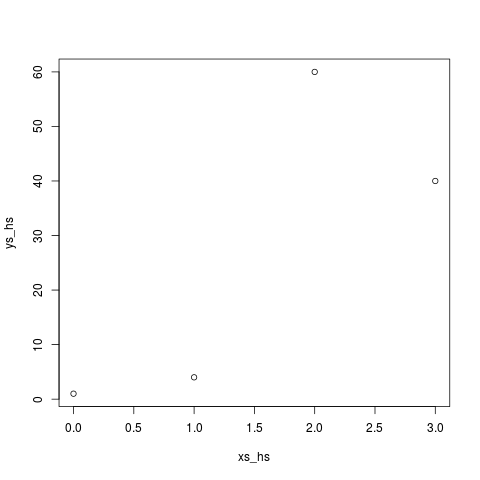

In [44]:
{-# LANGUAGE QuasiQuotes #-}

import Data.Int (Int32)

let xs = [0,1,2,3] :: [Int32]
    ys = [1, 4, 60, 40] :: [Int32]--[(0,0), (1, 5), (2, 0)] :: [(Int32, Int32)]

[rgraph|plot(x = xs_hs, y = ys_hs)|]

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAMAAABKCk6nAAAC/VBMVEUAAAABAQECAgIDAwMEBAQFBQUGBgYHBwcICAgJCQkKCgoLCwsMDAwNDQ0ODg4PDw8QEBARERESEhITExMUFBQVFRUWFhYXFxcYGBgZGRkaGhobGxscHBwdHR0eHh4fHx8gICAhISEiIiIjIyMkJCQlJSUmJiYnJycoKCgpKSkqKiorKyssLCwtLS0uLi4vLy8wMDAxMTEyMjIzMzM0NDQ1NTU2NjY3Nzc4ODg5OTk6Ojo7Ozs8PDw9PT0+Pj4/Pz9AQEBBQUFCQkJDQ0NERERFRUVGRkZHR0dISEhJSUlKSkpLS0tMTExNTU1OTk5PT09QUFBRUVFSUlJTU1NUVFRVVVVWVlZXV1dYWFhZWVlaWlpbW1tcXFxdXV1eXl5fX19gYGBhYWFiYmJjY2NkZGRlZWVmZmZnZ2doaGhpaWlqampra2tsbGxtbW1ubm5vb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISFhYWGhoaHh4eIiIiJiYmKioqLi4uMjIyNjY2Ojo6Pj4+QkJCRkZGTk5OUlJSVlZWWlpaXl5eYmJiZmZmampqbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSlpaWmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCxsbGysrKzs7O0tLS1tbW2tra3t7e4uLi5ubm6urq7u7u8vLy9vb2+vr6/v7/AwMDBwcHCwsLDw8PExMTFxcXGxsbHx8fIyMjJycnKysrLy8vMzMzNzc3Ozs7Pz8/Q0NDR0dHS0tLT09PU1NTV1dXW1tbX19fY2NjZ2dna2trb29vc3Nzd3d3e3t7f39/g4ODh4eHi4uLj4+Pk5OTl5eXm5ubn5+fo6Ojp6enq6urr6+vs7Ozt7e3u7u7v7+/w8PDx8fHy8vLz8/P09PT19fX29vb39/f4+Pj5+fn6+vr7+/v8/Pz9/f3+/v7///93gpTwAAAdoklEQVR4nO2dCXwVxRnAs+c78nIRkpAEiIAkAkIAoYAcggW04oEgKEVrKKVWKS14IFgFFSuUQw6pIHjUC0QqSKnSAgICAooKooTKZTjCkZBAuBJyzK+7LyR5eS8kM7O7s+9Nvn/DJtl9882Yf9++2Z2d+cIQwDVhdjcAsBYQzDkgmHNAMOeAYM4BwZwDgjkHBHMOCOYcEMw5IJhzQDDngGDOAcGcA4I5BwRzDgjmHBDMOSCYc0Aw54BgzgHBnAOCOQcEcw4I5hwQzDkgmHNAMOeAYM4BwZwDgjkHBHMOCOYcEMw5IJhzQDDngGDOAcGcA4I5BwRzDgjmHBDMOSCYc0Aw54BgzgHBnAOCOQcEcw4I5hwQzDkgmHNAMOeAYM4BwZwDgjkHBHMOCOYcA4JzlgFBwPIrVgn+8NcLAfvpfsAywfPpywKmMRIE8w0I5hwQzDkgmHNAMOeAYM4BwZwDgrni/Ifz5m8v890DgjmirLcQpiF/5LPPDMGl50pr2AuCmfNXSZIejZUkd17VPsOCL09qKYdJ108u9D8AgpmTrqrugr+oqvrvqn2GBT/Ub2PulTNb7/2t/wEQzJxuqurK+ZOqODZW7TMsOCrb++1iQ/8DIJg570mi2NYpStGXqvYZFpz+pvfbxx38D4Bg8/lfU28vqg5ivvcpYljw14mth44c2jbpa/8DINh0csNFoXbDgigOr17GeC+6eO3CaQvXFlftuHTQy9w5FP8JQG3MUhVZkWrxqyiqElHtMtik6+DTPv1ytGqIl9TbCJsP1MUfVVlV5Vrev6qi9aMvVCtjWPC+3ruzukhKzyP+B8beT9h8oC7WKJIs13aOlrUL4cTqZQwL7jKucOCYy4VP/cr/AAg2gTMPxDg0nE5V3zrEWj+Avahbq0cwLNhzEl2/H6GzEf4HQLBxvlL9T8JhgicpKVH/0v6XePXHpPLvyYmJaRMv+IUwLLjfrLJRCxFa0t7/AAg2TgtZw8evqP3qPEUUwrDgY51vuEfsfUvsVv8DINg4kVqnSfH50NU7UepaohAm9KJ3vTNj3spLAbtBsHEaKXK1XpWsXSY5fyIKYd1wIQi+Sn7Wkayso1na9kiW9+tn748/X/2t5qPlXy/539gQBKEjWe0g2GLeq+W6lQL54eK66/QFBFvLEacoijg3kGtGFCXpz4YaAIKtZZ7WS1IVar966SaGGgCCreVVEMw3Rw2eoiVJetxQA0AwGTuT6G1RIdxa0wNv+IBgIr5V6hiQrcGQIKQcPXb82PHjxzS0rfbd50fvfu0ru+ajJ4y2GAQT8UtZUWodzwlA0go4ttvXYhBMREutx6TWNuQegPfu4rv2tRgEE/GgXMeIbOA7WCvh2G9fi0Fw7Zwd2yIhXvufRqOE+Ph4jBFZP7TP4Idt/A8AwbXyeQ2XsILD6XLq/1xOp8uhf5VT+WP1o+EdNtj5XwCCayVe0k6x1c642u/JdreKBBBcG+dcWg9J9fnMFVRZUd2X7W4XASC4Nko9iobvO1i7TFKi7G4WCSC4Vu4PeNJcEMWRdreKBBAcyPbI2nrF8lhj9w4ZA4IDOOfxGR/Qfqw2nzrkAMEBrNL6VRUfvJL+1Fsvu1tkBBAcwFL97mKFYH00t5PdLTICCA7gpEuSKk/RknbhO9vuFhkBBFfjeCdJ8H+QMWBSTkgBgn352em1qzmOW7Do9YULF72+aEXgE98hBQj2ZZA+VUSQ9efL/2t3W0wCBPvSStXvXGn9KkV92e62mAQI9uUh73Cv9k9WN9ndFpMAwb7sKZ/ppX0Gd7a7KWYBgn3IEPQJuKIoxc+1uymmAYKr2Kqoe7R+VmO722EqILiKJ1TN7bdO93m7G2ImILiKGWocQmtUT4ndDTETEFzFSZc4/ECkyNfyTyC4iswEvQd9R8C6uSENCK7kfHT6xTPXJRJOsA52QHAlq8LzEdoX/q3d7TAXEFzJGxHam/dU+Dq722EuILiSn11zERrnOWt3O8ylvgvO7uUURUH0IoQJTvVtu1tkMvVc8G7fp9r1e9Ah/XhOTViXdSUkBLeTfVYa0xcKVL+0u0kmY13WlZAQHK8/VFcxY1AfCVZD+gGsGrAu60pICG6tvWkrF4OUZIWfceAKrMu6EtSCS9bP/Nv0GdP/Nrra1BTtM7hVWd2FQwrrsq4Es+A3qk0JFSpxjeVqoEHHuqwrQSz4hFOSJKHiuWfpl3a3x0osyLqyfZqXHncYbJp16HMXyienCPokhli722MlJmVdyff55chaL4MG0rfKYlZXzj4S9FVz4u1uj5UYFnznEXS0q6j0Oe5/IIhP0QURlfMHBVGSRtndHisxLNiRiYZmXLwy/l7/A0Ek+GyXWlY+Eu7irmPlixmCm+9DKD/S/0DwCC5N8Z9vpHWcxZiLdreLCcYFf158178R+iLJ/0DwCN7t1Bcg9PWrr7ShLLe7XUwwnlanqSP6BrQh+hX/A8Ej+D8+M7qvCtanAM+wu11MMKEXfeXAFrR9Q8Du4BGc45RkqdoSdVrPSlb32N0uJtSD4cKS52taVEX4nd3tYgP/gi/FC2GiIKiNkxs3Tm6ibbXvja+7N9PudjGCf8GPy/IzqKesrLa7IfbAv+BfKM7v0euKOtbuhtgD/4KHK8p7aISiLLa7IfbAv+AdqiC1FYXYEF9rgxbeBY8pvzwSe3L2NCw2nAteLonynDhJbGF3Q2yDc8ED9MHA+arqPmd3S+yCc8F3KWqcnj8QBF+DUBf8iSxKU2MlsaXdDbEN7gRPdtRwXzIx25a2BAO8Cf5tDTmz7+Rsyi8RnAku9cjVkywo2u8hlUTDbDgTnOfSlyH0eQ/rj0+6DtvQkmCBM8GogSxLvk+165PLIkIqyYLJ8CR4R/+kuKjAgV/pLdYN
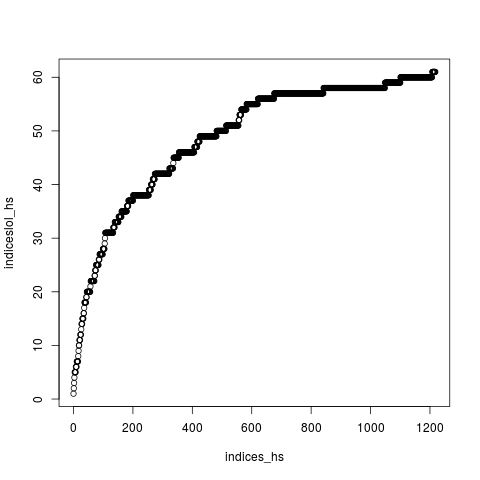

In [45]:
{-# LANGUAGE QuasiQuotes #-}
-- import Data.Int

let countryCountEvolution = snd <$> scanUniqueCount ccs    --  :: Vector Int32
    indices = V.toList $ V.enumFromN 0 (V.length countryCountEvolution) :: [] Int32
    indiceslol = V.toList $ fromIntegral <$> countryCountEvolution :: [] Int32
  
-- countryCountEvolution
[rgraph|plot(x = indices_hs, y = indiceslol_hs)|]

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nO3dZ1xUZ+K38aFJkWJDBRE1ItiwxQj2Fismim1jFLuIoia6JmhMNlk1UQGTGGNNEQWxYcMaFRR7B3vHgvTeO/O82H12/8maAArc95m5vi/2RaLw+2T18vbMzDk6arVaBQCQj67oAQCAVyPQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApAg0AkiLQACApfdEDgMqVm5ubnp6ek5OTmZlZUFCQnp7+hx9gbGxsZGSkq6trYWFRo0YNc3NzfX1+X0AK/EKE4uXn50dGRj558uTFixexsbFRUVGxsbF5eXnJuYUqlcrQ2NjIpHp1cwt9AwMjExMjk+p6+gb/+bklxUW52VkqlaqwoCAnKzM3Kys7M72osFBdUlLX1NjMzMzS0tLW1tbW1rbR/2dgYPCnU4AKpaNWq0VvAMohIyPj9u3bt2/fvnPnzr1796LTMg0MqtVr2Ki+baM6Vja161vVqle/pmU9g2rV3vx75eVkpyUlJsfHJka/TIyOSoyNTox5aa6rrlWrloODQ6tWrdq2bduqVSuSjUpCoPEK+/fv9/LyioqK6tSp09q1a1u0aCFwTH5+/tWrV69cuXL16tXnz5/n6BnaNnOwbda8YTOHhk3tDQwNq35SdkZGzNPHLx49eHrv9ssnj2oZ6jVt2rRz587Ozs4tW7bU1eWlHVQMAo0/iouLs7e337ZtW/fu3X18fPbt23fr1q0q3pCTk3PmzJkzZ85cunQpPiuvaes2zdq0b9q6raW1TRUvKQu1Wh3z9MnDG9ceRlyPevygSb063bt3792799tvv83lbLwJAo0/2rdv38qVK8+cOaNSqQoKCoyMjJKTk2vWrFkF3zo8PPzYsWMnT56MSc9u2dGplVOXZo7tqxkZVcG3rkDZGRn3rl26dfHskzs37RvUHzhw4KBBgxo1aiR6F5SHQOOPMjMzc3Nz69atq1KpTp8+PXHixCdPnujo6FTStysoKDh16lRwcPC1a9fMGzVr3713a6cuJmbmlfTtqlh6clL4mdBrYaG6mSldu3YdMWJEx44dK+8/JjQMgcarqdXq4OBgT0/PdevWvffeexX+9YuKik6cOLFjx46LN++0duraqe+At1q10eByFRcX3bt66eKxw2mR952dnUePHu3s7Cx6FGRHoPEKycnJ06ZNe/Hixfr16zt27FixX/zy5cubN28OOX/JsXP3bi5DG9o5VOzXl5y6pORBxLVzh/enPrnXv3//cePG2dnZiR4FSRFo/FF+fn6XLl0GDhy4ePFiPT29ivqy8fHx/v7+e/fuNbO16+06ulnbDhX1lRWquKgw4mzY6QO7jfKz3dzcRo0aZWxsLHoU5EKg8Uc7duxYtmzZvn37/vNPGjZs+CalPnv27Nq1a+9FxfZ2He307iAhb4yTWVZGeti+XeePHujX1dnDw6Nly5aiF0EWBBp/5OXl5e3t/X//SWJiYp06dcr7dfLz8wMCAvz8/MwaNRs4ZoKNnX3FbdRM969fObL1VwtVkaen58CBAzX4ijzKiECjHI4cOdK8efMmTZr89Q9LTU1dt27d5p17urkM7TPiA+PqplUzTzMkx8UeCdwUf/v6pEmT3NzcDPkLhxYj0CiHGzduLFmyJCgo6M9+QHx8vK+v7+GwswM+mNB5oIueHh/TeE35uTkndgXeCTk0evRod3d3U1P+kNNGfCYV5dC2bdvatWv/9ttv//uvYmNj582b9+7QEdXs2izx39PNZSh1fhOGxiYu46fO+3lnZJ5Ox+69fHx8cnJyRI9CVeMEjfJJTEwcOnTo6dOn//Mh5tTU1BUrVhw6dXbY1Jntu/cWO08jFRcXhe3ffXxHgOfk8dOnT+eih/bgBI3ysbS0HDly5IYNG1QqVW5urre3d+e+/dU29l/57aTOlURPT7/P8L8tCdhzJyWnZ8+egYGBnKu0BCdolFthYWHPnj0nT578yy+/dBgyqrfraN2Ke7s0/lpeTva+n9cm3g1fvHhx9+7dRc9B5SLQKLfr16+7u7ub2jRx/3KZkUl10XO0UXJc7ILRg/v27PHdd981aNBA9BxUFl7GQTmkpaV99tln4U9eTF2xpq6Nreg52uvu1YutHOy9vLzc3Nx69OixcOFCLkxrJK5Bo6wOHDjQqVdf0xYdPvnhJ+osUEFe3pGtm4KCgt5+++3jx4/XrVu3b9++58+fF70LFY9LHChdVFSUp6enbt2Gf5s1z9DYRPQcbbd9ta+lOm/NmjX/+SdxcXELFiwwNDT09fU1MzMTuA0Vi0CjFLt27frSe+WkBV81bd1W9BaokmJjFgzvl5SU9L8P1tqzZ4+Pj8/ixYv79esnZBsqHIHGn4qOjvbw8DBqaDdq5lx9nosqh+/+PmPqKNcJEya88t+mpqbOnj27Zs2a3t7e3BtPA3ANGq+2b9++vu8N6zHRc8xHn1JnSdy9cjHuwZ0/q7NKpapZs2ZAQEC3bt3efffdK1euVOU2VAZO0PijnJycuXPnRqZmTf5sMVec5aEuKfnHhJFbN65r165dqT84JiZm2rRpffr0mTdvHnfFUy5O0Pid+/fvDxgwwKL1OzOW+FJnqZwI2mZbu0ZZ6qxSqaytrQ8ePKivrz9kyJD4+PjK3oZKwgka/7V3794vlvvOXOpb37ax6C34nZyszJm9O0ZFRVlYWJTrJ549e/bTTz9duXJl586dK2kbKg+BhkqlUhUWFs6dO/dxcuakhf/kiScS2rxicYu6FsuXL3+Nn5ucnOzm5tazZ08vL68KH4ZKRaChSkxMHDdunH3vQb1d/yZ6C14h5lnkYjfXhISE1/4KxcXFixYtiomJ2bBhA+/uUBCuQWu7mzdvDhkypLubB3WW1hbvxevXr3+Tr6Cnp7d8+fLBgwcPGTLkTUKPKkagtdrBgwc/nOox1Xtdy3ecRW/Bq4WfOZmbEDN8+PA3/1IffPDBypUrhw4dGhER8eZfDVWAQGuvn3/++Z8rf1i4fnPt+lait+DViouLdq9ftXv37or6gu3atduxY8ecOXOOHTtWUV8TlYe72WkjtVrt5eV1OybJa82v3MpZZke3+rVqYmtvX5EPRLe1tT106NCYMWMSEhLGjRtXgV8ZFY4XCbVOUVHRlClTVPVsh06ZKXoL/kpGaspHA7rExcVVxst6BQUFkydPbtOmzaefflrhXxwVhUsc2iU/P3/s2LHVm7WhzvLbvsrby8urkt50Ua1atS1btsTGxnp5eXFKkxYnaC2SmZk5atSoNkNGOfcbLHoLSvH8wT0fj3ExMTGV/Y2WLFkSFxf3448/8olwCXGC1hYZGRmurq5OoydSZ0Xw9126efPmKvhGX3zxRZMmTcaPH19UVFQF3w7lQqC1
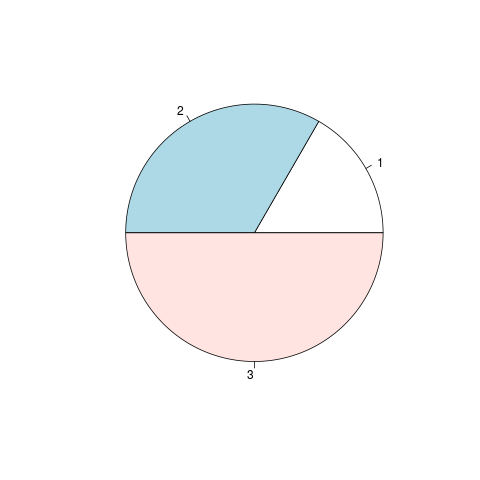

In [46]:
pieData = [10,20,30] :: [Double]
[rgraph|pie(c(pieData_hs))|]

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOzdeTxU3RsA8GsPWceMQbKUotXSQqEsKYSSok37Jm1KpVSSdpT2SCV7lBKiJImoXiVkRtbsS/Z9nd8f08/rtQ6GO8Pz/aPPuHPuuc+oHtc95zyHgUQiIQAAAGgPI9oBAAAA6BkkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAEAgEZBggYAABoFCRoAAGgUJGgAAKBRkKABAIBGQYIGAAAaBQkaAABoFCRoAACgUZCgAQCARkGCBgAAGgUJGgAAaBQkaAAAoFGQoAHoyt3dfcGCBePHj580adK1a9dIJBJ1+6+srOTl5aVun2BUYkY7AABoi6Oj4/Xr1+/cuSMnJ5eUlLRt2zYuLq7t27ejHRcYi+AOGoB/VVZW2traBgQELF++XEREZNmyZQ4ODr6+vuR37969O2HCBHZ2diUlpbS0NARBiESisrKyvb29iIiIhIREREREby0RBHFychIVFRUVFX348GHHFXtsCcBfJADA/71580ZGRqbHt4qLi1lZWSMjI0tLSzdt2rRr1y4SiUQgEDg5OS9cuFBXV3f06FElJaXeWn748IGPj+/Dhw+5ubmLFy/m4eHprSUAHeAOGoB/5eTkiIqK9vgWFxcXkUhctGgRFxeXsLBwZWUl+TgjI6OlpSUHB8fGjRvLy8t7a/n8+fNdu3apqqpOmDDBzs6u7z4BIINn0AD8C4/HFxUVdT7S0NDg6+trYmLCxsbm4+MTGBjIxMTExsaGxWLJDYSEhJiZmREEIf+JIEiPLYuKijQ1NckNvn37VltbO378eEFBQRkZmbKyMiYmpra2tp8/f3aJJzQ0dMWKFY2NjcP6qQHNgjtoAP6loKCQnp6elJTUcSQ8PNzKyoqNjc3f3//Zs2cvX76Mjo7evHlzRwMGBoYunfTYUkhIKDMzE0EQR0fH8+fPjxs3LjU11djY+M2bN2vWrImOjl65cmX3eGbNmtX5gTUYayBBA/AvPB5/8OBBAwODoKCg/Pz8iIiIgwcPmpubMzAwFBUVsbKyMjAwxMbGOjk5lZeXt7W19dhJjy2NjIycnZ3Dw8PPnj0rISHBwsIiIiKCx+PFxcVfvHgRGxv75MmTtrY2W1tbQUFBcXFx8nhjdXW1ra0tMsDRSDB6oP0QHADa0t7efvPmTXl5eXZ2dklJyfPnz7e0tJBIpPLycnV1dXZ2dkVFxZCQEDExMXd3dwKBMHXqVPKJHa97bEkikZycnAQEBJiZmV1dXUVERLq0vH//PoIga9asqa+vt7S0VFZW7twn5aORYDSBBA3AyHnw4IGWllaPbxEIBG5ubvIPg6SkpOnTp5P+m6C5uLg63iUfrK+vz8zMJJFIjY2NVlZWxsbGI/ZBwMiARxwA/BUQENDQ0DCsl+hxEPLx48fkYUA8Ht9lvLGz3kYjlZSUNDQ0Pn/+PKyRA1RAggbgL3d39+GeL9HHICTS03hjZxSORoLRBBI0AH+Rp74N6yX6GIQcRG+Uj1sCOgUJGoC/WlpaWFhYhvsqdnZ2FhYWZ86ckZKS2rFjx7Zt244dOza4rjZu3MjOzi4mJmZhYXHu3Llfv355e3tTN1qALgYStSt1AUCn1NTU3r9/j3YUAPwL7qABGAl+fn5ohwDoDyz1BqNcc3NzRUVFXV1dVVVVe3t7Q0ND95FAXl5eDg6OxsbGioqK8ePHU/1BR2Fhoa+v7+rVq6nbLZmAgEBZWVnHl5ycnLW1tcNxITDyIEEDutfY2JidnZ2ZmZmZmVlYWJifn19UVJSYmCguLoUgCAsLKw8PDw8PHzMzMycnF4Ig3NzcjIx/f3dsaGhoampCEKS6urK1FTE13V5VVdXS0szCgjAxMY0fPx6Hw02cOFFcXFxMTExMTGzChAmDSN+vX79etmwZVT/0f0RERMjJyQ1f/wAtkKABnampqUlMTPz58+fPnz+JRGJjfcW4cWwS4qIS4hMkxEVlp88SFloiLITTM9x53yWQnZ1jKNeqra0pLS0uKMjLy8tJSorIy/udn5+HIM0CAgLS0tJSUlLCwsLq6uqsrKx99/P69WsHB4ehRNI3Li6uzlu0EInE3bt3a2pqPn36NDEx8e7du+fPny8rK5OVlX3y5ImUlBSRSNy+ffuKFSuuXbvGysrq6uqqrq6OIIivr6+1tXVxcfGqVaucnZ1ZWFiioqL279+fm5u7bNkye3t7ISGh4fsUoDtI0IDWNTc3//PPP3FxcfHx8Tk5OVycTLNnyUyfJrVprYaM9E529nE9niUgwJeR8WvGDNmhXHr8eK7x47kkJCZ3OV5ZWZ6WRgwJefEy6LTk1KksbW3S0tIKCgrz5s2bOXNmx+05WVtbW2lp6cSJE4cSyUAlJCTIyMh4eHiUlJQcPHjwzZs306dPP3LkiIODw71798gNdHV109LSzp49a21t/enTp9TUVHNz81evXmGx2NWrVz948GDNmjWGhoaPHj1SVla2srIyNTV9+/btSH4KAAka0KKGhoaPHz++f//+y5cvpLZ6ebnpC5UUjPR3TxQVprAHHBaTlZU+xATdG15e/rlzF3z//tVg3TqrK1fa2toyiMSk+HhHFxfCjx94Pj4VFRVVVVUFBQVmZuZPnz7Nnz9/OMLosHjx4o7lhXfu3JGXl29ra3NycmJlZW1oaCASiRISEk1NTcLCwuSKesj/y1gzMzNv3Ljx5cuXCIL4+fmtXbtWUVERQRBnZ+fKysqgoCA1NTU9PT0EQRwdHQUEBNra2piYmIb1s4DOIEEDGvLjx4+QkJDIyMjW5hrlhXO0NRecPraht3vkvmEF+HNysqgeYWcEQrLBTlMEQZiYmKZMnz5l+vRVpqYIglSUlf0THe3i67v/6FFRLLahoWHTpk3DGomXl9esWbPIrwUEBPLy8vB4PPnBC+VlrPPy8qSkpMiv58yZgyCInZ1dcHAwHo8nH2RiYiopKYGnHCMJEjRAWUtLS0RERGBg4Ldv32ZNF9fVVjPfcZWLi3OI3eJwmE9fcqkSYW9+/86cp6ra/TgfBrPEwGCJgQGCICWFhU9u33bz87t169bChQuNjIwUFBSoHomwsLC4uHjnIx33ueTl4CEhITgczt3dPTg4mHy8+9pFQUHB/Px88usfP35kZWXh8XhjY+NHjx4hCNLe3p6Tk9ORrMHIgAQN0NHS0vLu3bunT5/+IiZqqC/YukHrlsOhwa147hFWgL+4+Cu1euuura2NkJrcY1WjznBCQkfs7BAEaW1t/RIVdd3VNWPfPmVlZSMjo7lz51Lx8/amy3Jwfn7+3paDr1y5csmSJSYmJkJCQubm5gYGBuvWrTtx4kRkZKSsrOz169dDQ0Pj4uKGO2DQGSRo
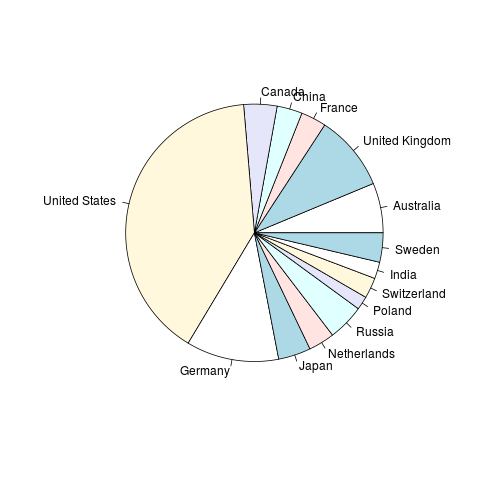

In [47]:
import qualified Data.HashMap.Strict as HMS

let countries = HMS.toList 
              $ HMS.filter (>15) 
              $ V.foldl' (\m c -> HMS.insertWith (+) c 1 m) HMS.empty ccs :: [(Country, Int)]
    labels = (countryName' . fst) <$> countries :: [String]
    occs   = (fromIntegral . snd) <$> countries :: [Int32]
    
[rgraph|pie(occs_hs, labels = labels_hs)|]

In [49]:
countryRatio :: Country -> Int -> Double
countryRatio c n = (fromIntegral n) / (fromIntegral population)
    where (CountryPopulation population)  = countryPopulation c

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOzdeVzM6R8A8O800913Omm6b6XooNAhOXJEIV2W2rRkkXPXOiPKrQiLJRRKiOgiR2jZcqTkSodramZKl+5rZn5/jO3Xdk410/dbfd5/7Guaeb7P86nVZ56e+T6fh8BmsxEAAAD4I4B1AAAAANoHCRoAAHAKEjQAAOAUJGgAAMApSNAAAIBTkKABAACnIEEDAABOQYIGAACcggQNAAA4BQkaAABwChI0AADgFCRoAADAKUjQAACAU5CgAQAApyBBAwAATkGCBgAAnIIEDQAAOAUJGgAAcAoSNAAA4BQkaAAAwClI0AAAgFOQoAEAAKcgQQMAAE5BggYAAJyCBA0AADgFCRoAAHAKEjQAAOAUJGgAAMApSNAAAIBTkKABAACnIEEDAABOQYIGAACcggQNAAA4BQkaAABwChI0AADgFCRoAADAKUjQAACAU5CgAQAApyBBAwAATkGCBgAAnIIEDQAAOAUJGgAAcAoSNAAA4BQkaAAAwClI0AAAgFOQoAEAAKcgQQMAAE5BggYAAJyCBA0AADgFCRoAAHAKEjQAAOAUJGgAAMApSNAAAIBTkKABAACnIEEDAABOQYIGAACcggQNAAA4BQkaAABwChI0AADgFCRoAADAKUjQAACAU5CgAQAApyBBAwAATkGCBgAAnIIEDQAAOAUJGgAAcAoSNAAA4BQkaAAAwClI0AAAgFOQoAEAAKcgQQMAAE5BggYAAJyCBA0AADgFCRoAAHAKEjQAAOAUJGgAAMApSNAAAIBTkKABAACnIEEDAABOQYIGAACcggQNAAA4BQkaAABwChI0AADgFCRoAADAKUjQAACAU5CgAQAApyBBA1y4cOGChYWFhISElpbWoUOH2Gw2giBZWVl6enqtWt6+fVtERIQfMcjJyRFakJCQ4McoAHCPhHUAACBBQUGHDx8+fvy4iYnJ69evf/nlFxRFFy9e3G5jQ0PDs2fP8imSpKQkExMTPnUOQHfBDBpgrLy8fOfOndHR0bNmzVJSUpo+fXpgYODly5c5r7LZ7ICAAHl5eXV19aSkJARBKioqdu7ciSBIVlaWlZXVwYMHlZSUNDQ0OK8iCHLixAllZWVRUVFzc/OcnJxuBYOiqFQLWVlZNjY2AQEBhoaG7fbcUQyXL1/W0dEhk8mLFi1qbGxEECQ5OdnY2FhWVnbBggV0Op03Pzsw0EGCBhh7/vy5oqLi6NGjm59xc3O7e/cu53FOTg6RSPz8+bOLi8v27dtbXZuRkdHY2JiTk+Pi4rJ161YEQYqKitasWRMeHk6lUnV1dQMDA3sZXkZGRkFBwcWLFzvquW0MHz588PHxuXDhQnp6+qtXr0JCQkpKShwdHf39/XNzc1EU9fDw6GVUYJCABA3+o921YB4qLy+XkpJq+czXr19VVFQ6ao+i6Pr160VFRT08PMrKylq9KiAgsH79ejExMXd399LSUk77rKysCRMmoCiqqKhYXl7erfBsbGyap88REREIgjCZzODgYENDw456bhvD1atX58+fP27cOC0trVOnTuno6MTFxU2cONHe3l5aWjooKOjJkydMJrNbgYHBCdagwf91ay2YVygUCoPBaPlMbW3t5cuX3dzcOK+SSCQEQTj/bUVBQaHVq8LCwpGRkTExMUQiUVhYeMiQId0KJiIigrOagSCInJxcfn4+hUIREhLqpOe2MeTn5+vo6HAem5qaIggSEBAQHx9PoVA4TxKJxKKiIgUFhW7FBgYhmEGDHzpfC+Z++bXdJeDg4GAVFRUVFZWWn+9xWs6bN+/Nmzfx8fHNz9+7d2/Tpk3CwsIIghAIhE5ibvtqVFTUtWvXbt68+fjxY09Pz+7+EBQVFdX/xbmLg0gkdt5z2xjk5eULCgo4j1+9enXjxg0KheLq6spgMBgMBo1Ge/36dXOyBqATkKDBD52sBXO//Npuy+Tk5B07doSHh6ekpMTGxnKubW6Zn59vYGAwf/78uLi4goKCpKSkNWvW+Pj4dJ6aO8JgMISEhAgEQkpKSnBwcGlpKa8WE7jvee7cuRcuXHj27BmVSvXx8cnNzbWzs4uPj3/48CHnXdDNza3z745EIuXm5jZ/GRoaOmXKlI4at7zvkEQiNTU1dfm9tF1oqqqqIhAIzes22dnZCgoKZ8+e7eVNjW0HAt0CCRr80MlaMPfLr+22vH79+tKlS62trZWVlQMCAtr2OWvWLB0dne3bt+vo6CxZsuSXX37ZsGFDz74Ld3d3UVFRNTW1devW+fv7Z2dnX7p0qWdd9bhnY2Pj/fv3u7q6jhgxQltbe+XKlYqKimFhYcuXL1dUVExOTg4PD+dJSBw8v+/w06dPkydP3rZtm5eXF19vagRdYwPAZrPZ7Li4OENDw5bP1NTUnDt3rra2lslk7t69e9y4cZaWlpMmTXJ1dWWz2e/fvx82bBin5fv373V1ddlsdrstXV1dT58+zWlJo9EkJSU7agk4iERiTk5O85fnzp2bPHkym81+//69paXlgQMHOEsx9+/fZ7f44dva2iIIoqqqWlVV9ejRIyMjIxkZmZ9++olGo3H6OXz4sLKysrKycmBgIOf/QrPKykoEQcrKyvLz8zU1NTmfD7fsvN2h2Wz22bNn1dTU1NXVQ0ND1dTUOhkoKipq2LBhZDJ57ty5hYWFbDY7JyfHwsLit99+k5WVtbS0TElJMTU1lZCQWLt2LZ9+sP0OJGjwA51OFxMTy8zMbH4mJiaGQqGwWKzLly+PHj2a80t1/vz55gTN+dVt+bjdlmvWrNm0aROnZUpKCuc3tt2W/FBdXR0fH995m5CQkIaGBj4F0AOdJGhxcfHdu3dXV1f/8ccf5ubm7P/+jyASiY2NjcXFxbKysjExMaWlpUuXLp0yZQqbzX706JG0tPSjR4+oVKqNjU27CfrDhw96enrr1q1rfr5lgm47dGZm5pAhQ549e5afn29paclJ0O0OlJeXJykpeffu3ZKSEk9PTxcXFzabnZOTQyAQzpw5U1JSMnr0aHl5+S9fvjx58gRBkJKSEr7+hPsLWOIAP1AolDVr1syePbvtWjD3y6/ttnRycjp16lRqampRUdH27ds5y6/8WyxupbKyMiwsrPM2V69eZbFY/Bid59ouK7XV7l197S40teLg4DBs2LDExMT6+npuho6MjPT09DQzM1NSUlq/fj2nWbsDxcTEzJkzZ8qUKTIyMvv3779+/Trnf7e0tLSHh4eMjMyUKVOcnJxUVVUtLCyUlJQqKip6/7MaACBBg/8LCAhYt25d27Vg7pdf221paWm5bds2JyenUaNGubq6iouLd6vPXiKTyZzpYSfq6+s599LhX9u7+tqiUqmcu/ooFIqmpibnrj4Gg6GlpcVpoKmp2e6FK1eujI6OlpGR8fPz42bogoICNTU1zuPmB+0OxGAw1NXVOY+HDBkiJCT07ds3zuPmPpvvbOnkWxts4AcB/o9AIPj4+Pj4+LR6Xlpa+v79+81ffv78mfMgKyuL80BPT4/zuKOWq1atWrVqFeexl5dXJy15TlRUtLa2tstmPbtphE9kZWUZDIa2tjbnSxqNJicnx3nMTZycu/rOnTuHIAiLxfr69SuFQlFQUPj48SOnwZcvX9q9cMGCBQICAmfPnh01atTs2bPHjRvX8tW2Q1MolK9fv3Ie5+fncx60OxCFQnn16hXncUlJSUNDg5ycXFVVVZffyyAHM2iAL93d+zcgOTo6rlu3LjU1lUaj3bhxIygoyMnJictrKysr272rr92FpnZpa2sHBAR4enp2+cbm5OQUGhr68uVLBoMRFBTU/GTbgezt7aOjo5OSksrKyn7//XcHBweYJnMDEjTAl19++YXzxy8PsXm9YZ3fDh48aG1t7erqqqWltXXr1gMHDnCZoJ2dndXU1CQlJdve1dfuQlNHfHx85OXl
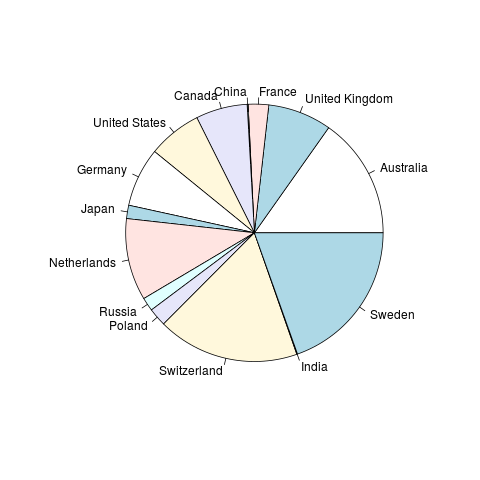

In [51]:
{-# LANGUAGE TupleSections #-}

let countriesRel = (\(c,n) -> (c,) $ countryRatio c n) <$> countries
    labels = (countryName' . fst) <$> countriesRel :: [String]
    occs   = snd <$> countriesRel :: [Double]
[rgraph|pie(occs_hs, labels = labels_hs)|]

In [52]:
import Data.List (sortBy)
import Control.Arrow (first)

let countriesByRatio = sortBy (flip compare `on` snd) countriesRel
mapM_ (print . first countryName') countriesByRatio

("Sweden",3.7645028745031746e-6)
("Switzerland",3.4296266983247594e-6)
("Australia",2.9280870193998313e-6)
("Netherlands",1.9825773505557223e-6)
("United Kingdom",1.539733619988963e-6)
("Germany",1.4302783846171872e-6)
("United States",1.2990242107265083e-6)
("Canada",1.247067905816681e-6)
("France",4.94068178845702e-7)
("Poland",4.4155844155844157e-7)
("Russia",3.2693209762476723e-7)
("Japan",3.2210420463830053e-7)
("China",2.4059354427372327e-8)
("India",1.7901164835444847e-8)

In [53]:
import Control.Arrow (second)

let baseline = snd $ head countriesByRatio
    countriesToBaseline = second (/ baseline) <$> countriesByRatio
    
mapM_ (print . first countryName') countriesToBaseline

("Sweden",1.0)
("Switzerland",0.9110437188276524)
("Australia",0.7778150573961959)
("Netherlands",0.5266505078223311)
("United Kingdom",0.4090137984533141)
("Germany",0.37993818368539567)
("United States",0.3450719136183284)
("Canada",0.33127027588769326)
("France",0.1312439371987217)
("Poland",0.11729528606528607)
("Russia",8.68460215129772e-2)
("Japan",8.556354328214205e-2)
("China",6.391110653766626e-3)
("India",4.7552533315059235e-3)

In [54]:
--githubUserCountry' "srsudar"

In [ ]:
-- let ucs = vecMapMaybe snd ccs

In [ ]:
--mapM_ print $ V.take 5 ucs

In [ ]:
--let countries = foldl' (\m c -> Map.insertWith (+) c 1 m) Map.empty ucs

In [ ]:
--Map.size countries

In [ ]:
--take 5 $ Map.assocs countries

In [ ]:
--import Data.Function (on)
--
--instance Eq Country where
--    (==)    = (==) `on` countryName
--instance Ord Country where
--    compare = compare `on` countryName

In [ ]:
--{-# LANGUAGE StandaloneDeriving #-}
--import Data.List
--deriving instance (Ord CountryPopulation)
--deriving instance (Eq CountryPopulation)
--
--let topCountries = sortBy (flip compare `on` snd) $ Map.toList countries
--mapM_ (print . countryName' . fst) $ take 10 topCountries

In [ ]:
--let countryAndRatios = map (\(c,n) -> (c, haskellRatio c n)) $ Map.toList countries

In [ ]:
--let topCountriesRatio = sortBy (flip compare `on` snd) $ Map.toList countryAndRatios

In [ ]:
--let topCountriesRel = sortBy (flip compare `on` uncurry haskellRatio) $ Map.toList countries
--mapM_ print $ take 10 topCountriesRel

In [ ]:
--r <- get "https://api.github.com/repos/jgm/pandoc/contributors"
--let contributors = r ^.. responseBody . values . key "login" . _String
--print (r ^? responseLink "rel" "next" . linkURL)

-- mapM (githubUserCountry . GithubUser) $ take 5 contributors